In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def DoRotation3D(xspan, yspan, zspan, RotRadX=0, RotRadY=0, RotRadZ=0):
    """Generate a 3D meshgrid and rotate it by RotRadX, RotRadY, and RotRadZ radians."""

    # Rotation matrices for x, y, and z axes
    RotMatrixX = np.array([[1, 0, 0],
                           [0, np.cos(RotRadX), -np.sin(RotRadX)],
                           [0, np.sin(RotRadX), np.cos(RotRadX)]])
    
    RotMatrixY = np.array([[np.cos(RotRadY), 0, np.sin(RotRadY)],
                           [0, 1, 0],
                           [-np.sin(RotRadY), 0, np.cos(RotRadY)]])
    
    RotMatrixZ = np.array([[np.cos(RotRadZ), -np.sin(RotRadZ), 0],
                           [np.sin(RotRadZ), np.cos(RotRadZ), 0],
                           [0, 0, 1]])

    # Combined rotation matrix
    RotMatrix = RotMatrixY @ RotMatrixZ

    # Create a 3D meshgrid
    x, y, z = np.meshgrid(xspan, yspan, zspan, indexing='ij')

    # Stack the meshgrid arrays into a single 4D array
    grid = np.stack([x, y, z], axis=-1)
    print(grid.shape)

    # Apply the rotation matrix
    rotated_grid = np.einsum('ij,klmj->klmi', RotMatrix, grid)

    return rotated_grid

(10, 10, 10, 3)


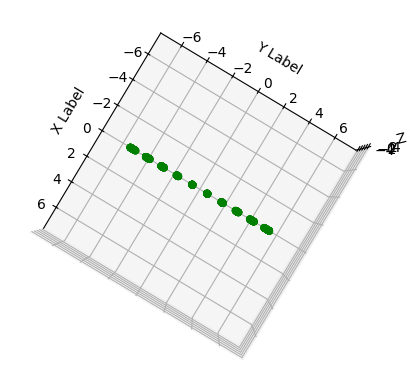

In [56]:
w = 10
sources = 10
x = np.linspace(-w/2, w/2, sources)
y = np.linspace(-w/2, w/2, sources)
z = np.zeros_like(x)

tilt_angle = np.deg2rad(90)
rotated_mesh = DoRotation3D(x, y, z, RotRadY=tilt_angle, RotRadZ=np.deg2rad(0))


# Extract the rotated coordinates
x_rot = rotated_mesh[..., 0]
y_rot = rotated_mesh[..., 1]
z_rot = rotated_mesh[..., 2]

# Plotting the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_rot, y_rot, z_rot, c='g', marker='o')

# Set view angle to look from the top
ax.view_init(elev=90, azim=30)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.axis("equal")

plt.show()

In [80]:
w = 10e-3
w_d = np.sqrt(2)*w
g = 1e-3
g_d = np.sqrt(2)*g
sources = 10
mirrors = 5
dmd_size = (w+g)*mirrors - g
dmd_size_d = np.sqrt(2)*dmd_size

# field parameters
field_dimensions = (300, 300)
res = 1  # number of pixels for a single field dimension point
pixels_x = res * field_dimensions[0]  # total number of pixels in x-direction
pixels_y = res * field_dimensions[1]  # total number of pixels in y-direction

# define the range where the field should be calculated
x_range = np.linspace(-field_dimensions[0]/2, field_dimensions[0]/2, pixels_x)
z_range = np.linspace(0, field_dimensions[1], pixels_y) - w/2
X, Z = np.meshgrid(x_range, z_range)
Y = np.zeros_like(X)

x = np.linspace(-w/2, w/2, sources)
y = np.linspace(-w/2, w/2, sources)
z = np.zeros_like(x)

tilt_angle = np.deg2rad(0)
xy_tilt_angle = np.deg2rad(45)
rotated_mesh = DoRotation3D(x, y, z, RotRadY=tilt_angle, RotRadZ=xy_tilt_angle)

# incident wave parameters
wl = 5e-3
k = 2*np.pi/wl
incident_angle = np.deg2rad(45)
k_wave = - k * np.array([
    np.sin(incident_angle),
    0,
    np.cos(incident_angle)
])

# projection of wave vector along x-axis
x_unit = np.array([1, 0, 0])
k_x = np.dot(k_wave, x_unit)*x_unit

# projection of wave vector along mirror
r_m = np.array([np.cos(tilt_angle), 0, np.sin(tilt_angle)])
k_m = np.dot(k_wave, r_m)*r_m

coords = np.zeros((mirrors, mirrors, 3, sources, sources, sources))
phase_shifts = np.zeros((mirrors, mirrors, sources, sources))
epsilon0 = 1e-10
E_total = np.zeros_like(X, dtype=complex)

for i in range(mirrors):
    for j in range(mirrors):
        # Extract the rotated coordinates
        # x_rot = rotated_mesh[..., 0] + np.sqrt(2)*((w+g)*i/2 - (w+g)*j/2)
        # y_rot = rotated_mesh[..., 1] + np.sqrt(2)*((w+g)*i/2 + (w+g)*j/2)
        # z_rot = rotated_mesh[..., 2]

        x_rot = rotated_mesh[..., 0] + np.sqrt(2)/2*(w+g)*(i - j)
        y_rot = rotated_mesh[..., 1] + np.sqrt(2)/2*(w+g)*(i + j - (mirrors-1))
        z_rot = rotated_mesh[..., 2]

        coords[i, j, 0] = x_rot
        coords[i, j, 1] = y_rot
        coords[i, j, 2] = z_rot

        mirror_x0 = x_rot[0, 0, 0]
        for sx in range(sources):
            for sy in range(sources):
                # extract current coordinates
                x_coord = x_rot[0, sx, sy] #+ np.sqrt(2)*w/2
                y_coord = y_rot[0, sx, sy] #+ np.sqrt(2)*w/2
                z_coord = z_rot[0, sx, sy]

                # calculate phase shift
                
                mirror_x = x_rot[0, sx, sy]
                mirror_dist = mirror_x-mirror_x0
                source_dist = np.sqrt(np.square(mirror_x-x_coord)+np.square(z_coord))
                mirror_phase = np.dot(k_x, x_unit)*mirror_x  # phase shift of current (i-th) mirror y-row
                source_phase = np.dot(k_m, r_m)*source_dist  # phase shift of point source
                phase_shift = mirror_phase + source_phase
                # print(phase_shift)
                phase_shifts[i, j, sx, sy] = phase_shift

                # calculate field 
                r = np.sqrt(np.square(X - x_coord) + np.square(Y - y_coord) + np.square(Z - z_coord))
                E_total += np.exp(1j * (k * r + phase_shift))/(r + epsilon0)

(10, 10, 10, 3)


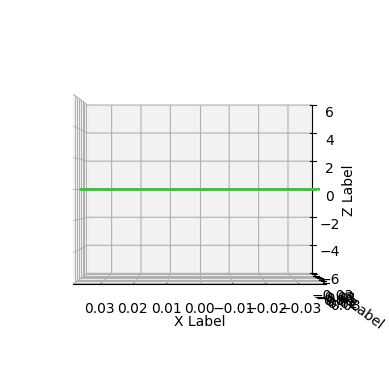

In [81]:
# Plotting the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_all = [coords[i, j, 0] for i in range(mirrors) for j in range(mirrors)]
y_all = [coords[i, j, 1] for i in range(mirrors) for j in range(mirrors)]
z_all = [coords[i, j, 2] for i in range(mirrors) for j in range(mirrors)]
ax.scatter(x_all, y_all, z_all, c="limegreen", marker='o', s=0.5)
ax.scatter(coords[0, 0, 0, 0, 0], coords[0, 0, 1, 0, 0], coords[0, 0, 2, 0, 0], c="red", marker='o', s=0.5)

# Set view angle
ax.view_init(elev=0, azim=90)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim3d(-6, 6)
ax.set_xlim3d(-dmd_size_d/2, dmd_size_d/2)
ax.set_ylim3d(-dmd_size_d/2, dmd_size_d/2)

plt.show()

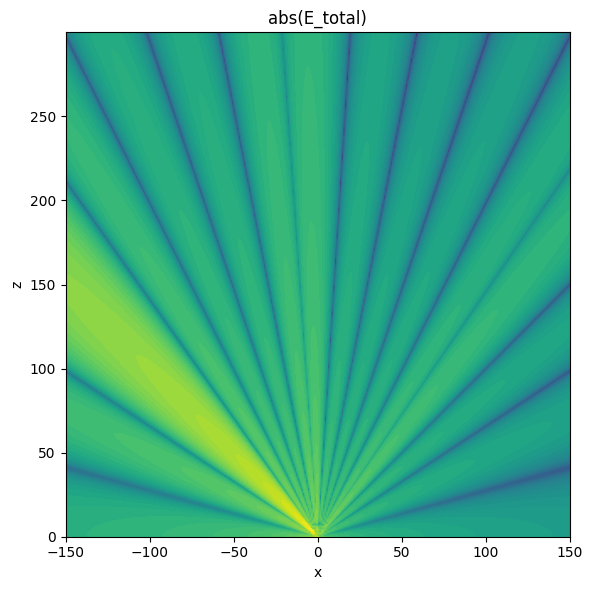

In [82]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot the real part of the total reflected field
plt.contourf(X, Z, np.log(np.abs(E_total)), levels=50, cmap='viridis')
plt.title('abs(E_total)')
plt.xlabel('x')
plt.ylabel('z')
plt.axis("square")

plt.tight_layout()
plt.show()